In [29]:
#pip install --force-reinstall --no-deps torch==2.1.2


In [1]:
#pip install torch --upgrade.  
# Comment: earlier versions of my program did not work because there was an error in Pytorch and this wasted days of my time
# So make sure the most updated version!                
           
import torch                                         # imports the core PyTorch library
import torch.nn as nn                                # torch.nn library is a high-level interface for building and training neural networks
import torch.optim as optim                          # Needed for optimizer
from torch.utils.data import DataLoader              # Needed for loading data from Sugarcane png files
from torchvision import datasets, transforms         # Needed for making sure data from  Sugarcane png files is properly formatted 
import torch.nn.functional as F                      # Needed for functional equation in forward loop
import numpy as np                                   # Needed for outputting weights and biases
from torchvision.datasets import VisionDataset       # VisionDataset is is designed to be a base class for datasets in computer vision tasks
from PIL import Image                                # Needed for manipulating  Sugarcane png image files 
import os                                            # Needed for operating system for dealing with dir of training and test png files
from torchvision import transforms
from skimage import exposure
import matplotlib.pyplot as plt

# Set the device
device = "mps" if torch.backends.mps.is_available() else "cpu"
# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")

Is MPS (Metal Performance Shader) built? True


In [2]:
class Sugarcane(VisionDataset):
    def __init__(self, root, train=True, transform=None, target_transform=None):
        super(Sugarcane, self).__init__(root, transform=transform, target_transform=target_transform)

        self.train = train
        self.data_folder = "training" if train else "testing"
        self.images_folder = os.path.join(self.root, self.data_folder)

        self.image_paths = self._get_image_paths()

    def _get_image_paths(self):
        image_paths = []
        for digit_folder in os.listdir(self.images_folder):
            digit_folder_path = os.path.join(self.images_folder, digit_folder)

            # Check if it's a directory before listing its contents
            if os.path.isdir(digit_folder_path):
                for image_name in os.listdir(digit_folder_path):
                    image_path = os.path.join(digit_folder_path, image_name)
                    image_paths.append((image_path, int(digit_folder)))

        return image_paths

    def __getitem__(self, index):
        image_path, label = self.image_paths[index]

        # Skip files with the '.DS_Store' extension
        if image_path.endswith('.DS_Store'):
            return self.__getitem__(index + 1)

        image = Image.open(image_path)

        # Check if the image has an alpha channel (4 channels)
        if image.mode == 'RGBA':
            image = image.convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.image_paths)
    

In [3]:
transform = transforms.Compose([
    transforms.Resize((244, 244)),
    transforms.ToTensor()])
# this considers the colors of the image
# Assuming 'image' is your RGB image tensor (H x W x C)
#transformed_image = transform(image)


In [4]:
# Split the dataset into training and validation sets
# Download the Sugarcane PNG files to your Desktop from this site (kaggle)

Sugarcane_dataset = Sugarcane(root='/Users/peternoble/Downloads/Sugarcane_true', train=True, transform=transform)
#Sugarcane_dataset = Sugarcane(root='/Users/peternoble/Desktop/Sugarcane', train=True, transform=transform)
train_size = int(0.7 * len(Sugarcane_dataset))
val_size = len(Sugarcane_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(Sugarcane_dataset, [train_size, val_size])

In [5]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True) 
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)   

In [6]:
inputs, labels = next(iter(train_loader))
print(inputs.shape)


torch.Size([32, 3, 244, 244])


In [7]:
# Print the size of the training and validation datasets
print(f'Training dataset size: {len(train_loader.dataset)}')
print(f'Validation dataset size: {len(val_loader.dataset)}')

Training dataset size: 1765
Validation dataset size: 757


In [8]:
# Set the path where you want to save the images. Useful for visualizing the actual images used for validation
output_path = '/Users/peternoble/Desktop/results'
# Ensure the output directory exists
os.makedirs(output_path, exist_ok=True)
# Variables to store all images and labels
all_images = []
all_labels = []

# Iterate through the validation loader and concatenate images and labels
for batch_idx, (images, labels) in enumerate(val_loader):
# Apply histogram equalization to each image in the batch
#    equalized_images = torch.stack([torch.tensor(exposure.equalize_hist(img.numpy())) for img in images])

#    all_images.append(equalized_images)
    all_images.append(images)
    all_labels.append(labels)

# Concatenate the lists to get all images and labels
all_images = torch.cat(all_images, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Define a function to save images
def save_images(images, labels, output_path):
    for i in range(len(images)):
        image, label = images[i], labels[i]
        # Assuming the images are in the range [0, 1], and using torchvision to convert to PIL
        image_pil = transforms.ToPILImage()(image)
        image_pil.save(os.path.join(output_path, f"image_{i}_label_{label}.png"))

# Save all equalized images from the validation dataset
save_images(all_images, all_labels, output_path)

In [9]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=2, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        # Adjust the input size of the fully connected layer based on the output size of the previous layers
        self.fc1 = nn.Linear(32 * 122 * 122, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.flatten(x)
        x = self.fc1(x)
        return x

In [10]:
# Initialize the model
model = SimpleModel()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
# Assuming dataset is your DataLoader
for inputs, labels in Sugarcane_dataset:
    print("Input shape:", inputs.shape)
    break

Input shape: torch.Size([3, 244, 244])


Epoch 1/10, Training Loss: 14.0037, Training Accuracy: 0.3513, Validation Loss: 2.3837, Validation Accuracy: 0.4306
Epoch 2/10, Training Loss: 1.2313, Training Accuracy: 0.4901, Validation Loss: 1.1191, Validation Accuracy: 0.6301
Epoch 3/10, Training Loss: 0.6111, Training Accuracy: 0.5879, Validation Loss: 0.9394, Validation Accuracy: 0.6605
Epoch 4/10, Training Loss: 0.3231, Training Accuracy: 0.6612, Validation Loss: 1.0609, Validation Accuracy: 0.6922
Epoch 5/10, Training Loss: 0.1865, Training Accuracy: 0.7173, Validation Loss: 0.9948, Validation Accuracy: 0.6843
Epoch 6/10, Training Loss: 0.1290, Training Accuracy: 0.7581, Validation Loss: 0.9225, Validation Accuracy: 0.7252
Epoch 7/10, Training Loss: 0.0642, Training Accuracy: 0.7911, Validation Loss: 0.9722, Validation Accuracy: 0.7133
Epoch 8/10, Training Loss: 0.0448, Training Accuracy: 0.8167, Validation Loss: 0.9488, Validation Accuracy: 0.7252
Epoch 9/10, Training Loss: 0.0262, Training Accuracy: 0.8367, Validation Loss: 

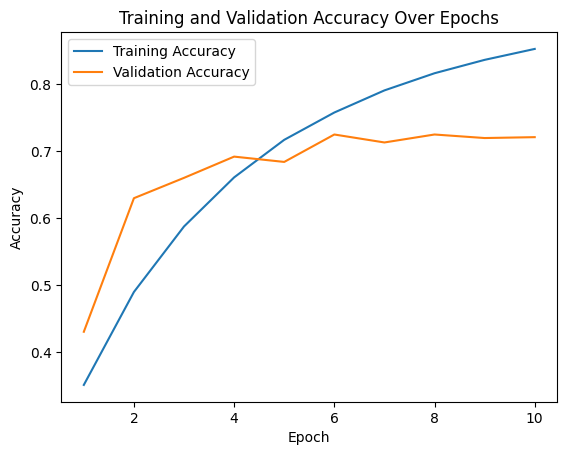

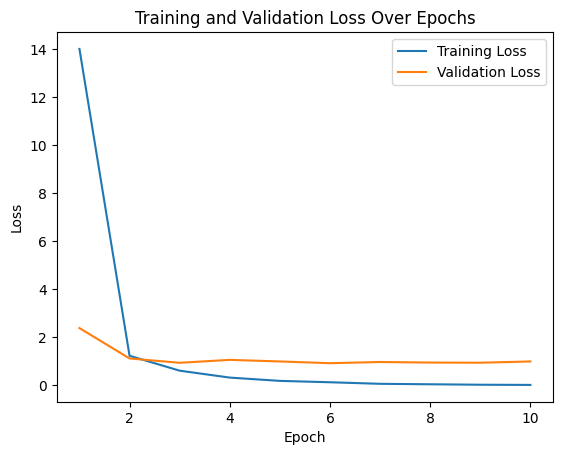

In [12]:
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
correct_train = 0
total_train = 0
correct_val = 0
total_val = 0

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

        _, predicted_train = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted_train.eq(labels).sum().item()

    average_train_loss = running_train_loss / len(train_loader)
    train_losses.append(average_train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    running_val_loss = 0.0

    # Reset variables for accuracy calculation
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            running_val_loss += val_loss.item()

            _, predicted_val = val_outputs.max(1)
            total_val += val_labels.size(0)
            correct_val += predicted_val.eq(val_labels).sum().item()

    average_val_loss = running_val_loss / len(val_loader)
    val_losses.append(average_val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {average_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Plotting the accuracy curve
epochs = range(1, len(train_accuracies) + 1)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

# Plotting the loss curve
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [13]:
# Save the model state_dict
torch.save(model.state_dict(), '244_10_epochs.pth')

In [14]:
# Assuming you have a validation DataLoader named val_loader
loaded_model = SimpleModel()
loaded_model.load_state_dict(torch.load('244_10_epochs.pth'))
#loaded_model.eval() 

model.eval()                                          # Set the model to evaluation mode
all_predictions = []
all_labels = []                                       # This list was missing in the original code

with torch.no_grad():
    for inputs, labels in val_loader:
        try:
            # Ensure the input size is correct
            inputs = inputs.view(inputs.size(0), 3, 244, 244)
            #inputs = inputs.view(inputs.size(0), 3, 488, 488)

            outputs = model(inputs)
            predictions = torch.argmax(outputs, dim=1)
            all_predictions.extend(predictions.tolist())
            all_labels.extend(labels.tolist())  # Populate the true labels
        except Exception as e:
            print(f"An error occurred: {e}")

# Now you have lists of all predicted labels and true labels
# You can compare them to compute accuracy or analyze the classification breakdown

# Compute accuracy
if len(all_labels) > 0:
    accuracy = sum(p == l for p, l in zip(all_predictions, all_labels)) / len(all_labels)
    print(f"Accuracy: {accuracy:.2%}")
else:
    print("No labels available for computing accuracy.")
# Your custom labels
custom_labels = ['Healthy', 'Yellow', 'Rust', 'RedRot', 'Mosaic']

# Analyze classification breakdown
for class_label in range(len(custom_labels)):
    correct = sum(p == class_label and l == class_label for p, l in zip(all_predictions, all_labels))
    total = all_labels.count(class_label)
    
    if total == 0:
        print(f"Class {custom_labels[class_label]}: No examples in the validation set")
    else:
        percentage = correct / total if total != 0 else 0.0
        print(f"{custom_labels[class_label]}: {correct}/{total} ({percentage:.2%})")



Accuracy: 72.13%
Healthy: 115/152 (75.66%)
Yellow: 105/138 (76.09%)
Rust: 118/163 (72.39%)
RedRot: 116/164 (70.73%)
Mosaic: 92/140 (65.71%)


In [15]:
# Assuming you have a validation DataLoader named val_loader
loaded_model = SimpleModel()
loaded_model.load_state_dict(torch.load('244_10_epochs.pth'))

model.eval()  # Set the model to evaluation mode
params = list(loaded_model.parameters())
print(params[0].shape)
print(params[1].shape)
print(params[2].shape)
print(params[3].shape)

flattened_weights = params[0].data.flatten()
np.savetxt('weights_0.txt', flattened_weights)

flattened_weights1 = params[1].data.flatten()
np.savetxt('biases_0.txt', flattened_weights1)

print (flattened_weights1)
flattened_weights2 = params[2].data.flatten()
np.savetxt('weights_1.txt', flattened_weights2)

flattened_weights3 = params[3].data.flatten()
np.savetxt('biases_1.txt', flattened_weights3)

# Print the weights and biases
for name, param in loaded_model.named_parameters():
    if 'weight' in name or 'bias' in name:
        print(f"Parameter: {name}, Shape: {param.shape}")
        print("Values:")
        print(param.data)
        print("\n")

torch.Size([32, 3, 2, 2])
torch.Size([32])
torch.Size([5, 476288])
torch.Size([5])
tensor([ 0.1399,  0.2444,  0.0356,  0.0575, -0.0547,  0.0273,  0.0954, -0.1022,
        -0.0263,  0.2364, -0.2725,  0.2721, -0.0651, -0.0576, -0.1025,  0.1305,
         0.0803, -0.1817, -0.1563, -0.2643, -0.1689,  0.0618, -0.1050, -0.0124,
        -0.2040, -0.1170, -0.0611, -0.2142,  0.1345, -0.0018, -0.2511, -0.1311])
Parameter: conv1.weight, Shape: torch.Size([32, 3, 2, 2])
Values:
tensor([[[[ 7.8986e-02,  2.3883e-01],
          [-1.3255e-01, -1.6590e-01]],

         [[-3.3597e-02, -6.2142e-02],
          [ 1.5637e-01, -2.2117e-01]],

         [[-3.0068e-01, -1.2209e-01],
          [-8.3980e-03,  1.6060e-01]]],


        [[[ 7.5073e-02, -4.7525e-02],
          [-6.6986e-02, -2.2751e-02]],

         [[ 2.3166e-01, -2.3633e-01],
          [-3.0123e-01,  5.5085e-02]],

         [[ 2.2719e-02, -3.8310e-02],
          [-2.0552e-01, -1.7857e-01]]],


        [[[ 1.9131e-01,  2.0604e-01],
          [ 8.9179e-